# Imports

### Libraries

In [1]:
import os
from pathlib import Path
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tabulate import tabulate

import torch
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import transforms
from torchvision import transforms, models

# Resources Import

In [2]:
!git clone https://github.com/Luca-Olivieri/NAML_project.git

fatal: destination path 'NAML_project' already exists and is not an empty directory.


### Resources paths

In [3]:
local_path = "/content/"
project_path = local_path+"NAML_project"
dataset_path = local_path+"neuroendocrine_"

### Scripts

In [4]:
import sys

sys.path.append(f"{project_path}/src/")

In [5]:
import models_manager
import data_manager
import eval_manager

### Seeds

In [6]:
seed_value = 42

np.random.seed(seed_value)  # NumPy
torch.manual_seed(seed_value)  # PyTorch CPU
torch.cuda.manual_seed_all(seed_value)  # PyTorch GPU

# Model Import

Import one of the pre-trained models.

Available models:

- Inception v3
- AlexNet

In [7]:
model_name = "inceptionv3"
# model_name = "AlexNet"

Select version:

In [8]:
version = "v1"

In [9]:
model = models_manager.import_model(model_name)

In [10]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [11]:
models_manager.setup_model(model, device)

# Data Ingestion

Download dataset from GitHub:

In [12]:
!git clone https://github.com/cialab/neuroendocrine_

fatal: destination path 'neuroendocrine_' already exists and is not an empty directory.


# Training/Loading

Control the training/loading and saving functionalities:

- **training**: if yes, performs the computational training of the model. Otherwise, downloads and loads the already trained parameters.
- **save**: if yes, saves the current state of the model (regardless of the fact that the training has been performed or not).

**Important**: write operations are performed even if files are already present in the runtime. Hence, old files are over-written.

In [13]:
training = True
save = True # regardless of the actual training

Dataset is very unbalanced, so I create a dataset containing 50% tumor and 50% non tumor subimages.
I tried to trained on the original unbaiased dataset and the network pretty much always predicted tumor (because in training 90% of subimages are tumor)

In [14]:
if training == True:

	batch_size = 100
	undersampled_loader = data_manager.create_dataloader(batch_size, n=70000, p=0.575)
	# n denotes the number of 64x64 images,
	# p denote the percentage of non-tumor images

	# optimizer = optim.SGD(inceptionv3.parameters(), lr=0.001, momentum=0.9)
	optimizer = optim.Adam(model.parameters(), lr=0.00075)
	
	class_weights = [3, 1]

	# Proceed with the training loop
	models_manager.train(model, optimizer, undersampled_loader, class_weights, device,
	                     num_epochs=1, max_train=700, print_every=10)

else:

	# Load custom pre-trained parameters
	models_manager.load_params(model, local_path, project_path, version, device)

Shape of the train_images array: (784238, 64, 64, 3)
Shape of the train_labels array: (784238,)
Shape of the train_images array: (70000, 64, 64, 3)
Shape of the train_labels array: (70000,)
Iteration [10/700], Epoch [1/1], Loss: 0.5439
Iteration [20/700], Epoch [1/1], Loss: 0.4195
Iteration [30/700], Epoch [1/1], Loss: 0.3317
Iteration [40/700], Epoch [1/1], Loss: 0.3697
Iteration [50/700], Epoch [1/1], Loss: 0.3109
Iteration [60/700], Epoch [1/1], Loss: 0.3434
Iteration [70/700], Epoch [1/1], Loss: 0.3264
Iteration [80/700], Epoch [1/1], Loss: 0.2937
Iteration [90/700], Epoch [1/1], Loss: 0.3055
Iteration [100/700], Epoch [1/1], Loss: 0.2982
Iteration [110/700], Epoch [1/1], Loss: 0.2755
Iteration [120/700], Epoch [1/1], Loss: 0.2894
Iteration [130/700], Epoch [1/1], Loss: 0.2822
Iteration [140/700], Epoch [1/1], Loss: 0.2653
Iteration [150/700], Epoch [1/1], Loss: 0.2966
Iteration [160/700], Epoch [1/1], Loss: 0.3037
Iteration [170/700], Epoch [1/1], Loss: 0.2632
Iteration [180/700],

### Parameters saving

In [15]:
if save == True:
   models_manager.save_params(model, local_path)

# Testing

Control the prediction/loading and writing functionalities:

- **pred**: if yes, performs the computational prediction of a selected image's segmentation. Otherwise, loads the file avg.png from the Colab runtime (if it is not present, it downloads it from th GitHub project's repo).
- **avg_write**: if yes, write to the Colab runtime the raw output of the model based on the chosen image (regardless of the fact that the computation has been performed or not).
- **output_write**: if yes, write to the Colab runtime the thresholded output of the model based on the chosen image (regardless of the fact that the computation has been performed or not).

**Important**: write operations are performed even if files are already present in the runtime. Hence, old files are over-written.

In [16]:
compute = True # If true, compute the mask prediction of a chosen image; otherwise, consider the already pre-computed prediction
avg_write = True # Write the avg photo to Colab, regardless of the actual computation or not
output_write = False # Write the final output photo to Colab

In [17]:
img_idx = 29 # index of image chosen for evaluation (loaded avg.png refers to -1)

### Target visualisation

Available photos:

In [18]:
images_paths = data_manager.get_images(dataset_path, test=False)
masks_paths = data_manager.get_images(dataset_path, test=True)

In [19]:
images_paths

[PosixPath('/content/neuroendocrine_/images/HotSpot02_1.tif'),
 PosixPath('/content/neuroendocrine_/images/HotSpot02_2.tif'),
 PosixPath('/content/neuroendocrine_/images/HotSpot02_3.tif'),
 PosixPath('/content/neuroendocrine_/images/HotSpot09_1.tif'),
 PosixPath('/content/neuroendocrine_/images/HotSpot09_2.tif'),
 PosixPath('/content/neuroendocrine_/images/HotSpot09_3.tif'),
 PosixPath('/content/neuroendocrine_/images/HotSpot12_1.tif'),
 PosixPath('/content/neuroendocrine_/images/HotSpot12_2.tif'),
 PosixPath('/content/neuroendocrine_/images/HotSpot12_3.tif'),
 PosixPath('/content/neuroendocrine_/images/HotSpot15_1.tif'),
 PosixPath('/content/neuroendocrine_/images/HotSpot15_2.tif'),
 PosixPath('/content/neuroendocrine_/images/HotSpot15_3.tif'),
 PosixPath('/content/neuroendocrine_/images/HotSpot18_1.tif'),
 PosixPath('/content/neuroendocrine_/images/HotSpot18_2.tif'),
 PosixPath('/content/neuroendocrine_/images/HotSpot18_3.tif'),
 PosixPath('/content/neuroendocrine_/images/HotSpot29_1

Considered photo:

In [20]:
images_paths[img_idx], masks_paths[img_idx]

(PosixPath('/content/neuroendocrine_/images/HotSpot02_1.tif'),
 PosixPath('/content/neuroendocrine_/masks/HotSpot02_1.tif.png'))

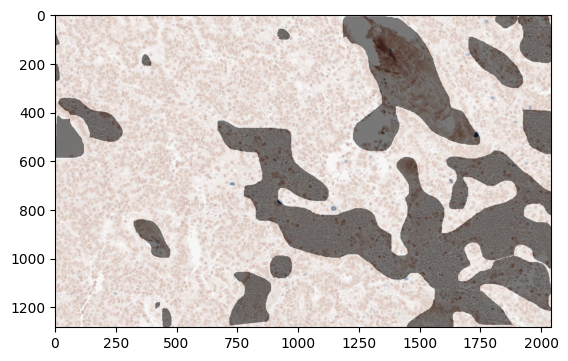

In [21]:
testImage = cv2.imread(str(images_paths[img_idx]))
testMask = cv2.imread(str(masks_paths[img_idx]))

plt.imshow(testImage)
plt.imshow(testMask, alpha=0.5)

### Mask prediction

In [22]:
if compute == True:
  avg = models_manager.predict(model, device, testImage)

else:
  avg = models_manager.get_prediction(
      model, local_path, project_path, version)

Row 0/ 1300
Row 200/ 1300
Row 400/ 1300
Row 600/ 1300
Row 800/ 1300
Row 1000/ 1300
Row 1200/ 1300


### Mask predition saving

In [23]:
if avg_write == True:
   cv2.imwrite('avg.png', avg*255)

Visualisations

Raw output of the segmentation:

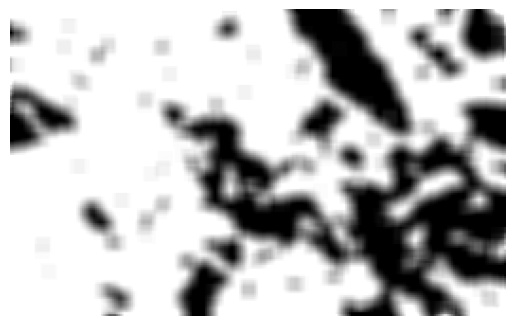

In [24]:
raw_output = models_manager.beautify_output(avg)
models_manager.visualise_output(raw_output)

Thresholded output:

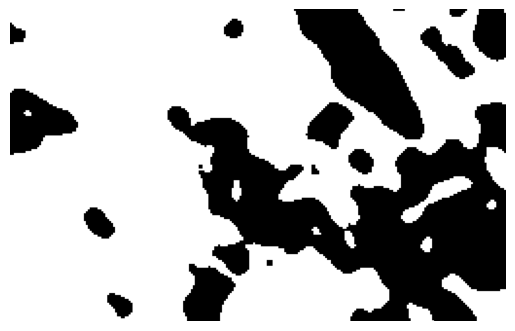

In [25]:
thr = 0.5 # threshold

thr_output = models_manager.threshold_output(avg, thr)
models_manager.visualise_output(thr_output)

Prediction saving:

In [26]:
if output_write == True:
  models_manager.save_prediction(thr_output)

# Evaluation

###Metrics

In [27]:
tumor = True

In [28]:
y_true = eval_manager.get_true_labels(testMask, tumor)
y_pred = eval_manager.get_pred_labels(thr_output, tumor)

Compute metrics:
- Accuracy
- ...

In [29]:
acc = eval_manager.pixel_accuracy(y_true, y_pred)
prec = eval_manager.pixel_precision(y_true, y_pred)
recall = eval_manager.pixel_recall(y_true, y_pred)
iou = eval_manager.intersection_over_union(y_true, y_pred)
dice = eval_manager.dice_coefficient(y_true, y_pred)

Show metric table:

In [30]:
eval_manager.show_metrics(acc, prec, recall, iou, dice)

+-----------------+---------+
| Metric          |   Value |
+=================+=========+
| Pixel Accuracy  |  0.9173 |
+-----------------+---------+
| Pixel Precision |  0.9702 |
+-----------------+---------+
| Pixel Recall    |  0.9113 |
+-----------------+---------+
| IoU             |  0.8864 |
+-----------------+---------+
| Dice Coeff.     |  0.9398 |
+-----------------+---------+


### Confusion matrix:

In [31]:
conf_matrix = eval_manager.conf_matrix(y_true, y_pred)
conf_norm_matrix = eval_manager.conf_matrix(y_true, y_pred,
                                            normalise="true")

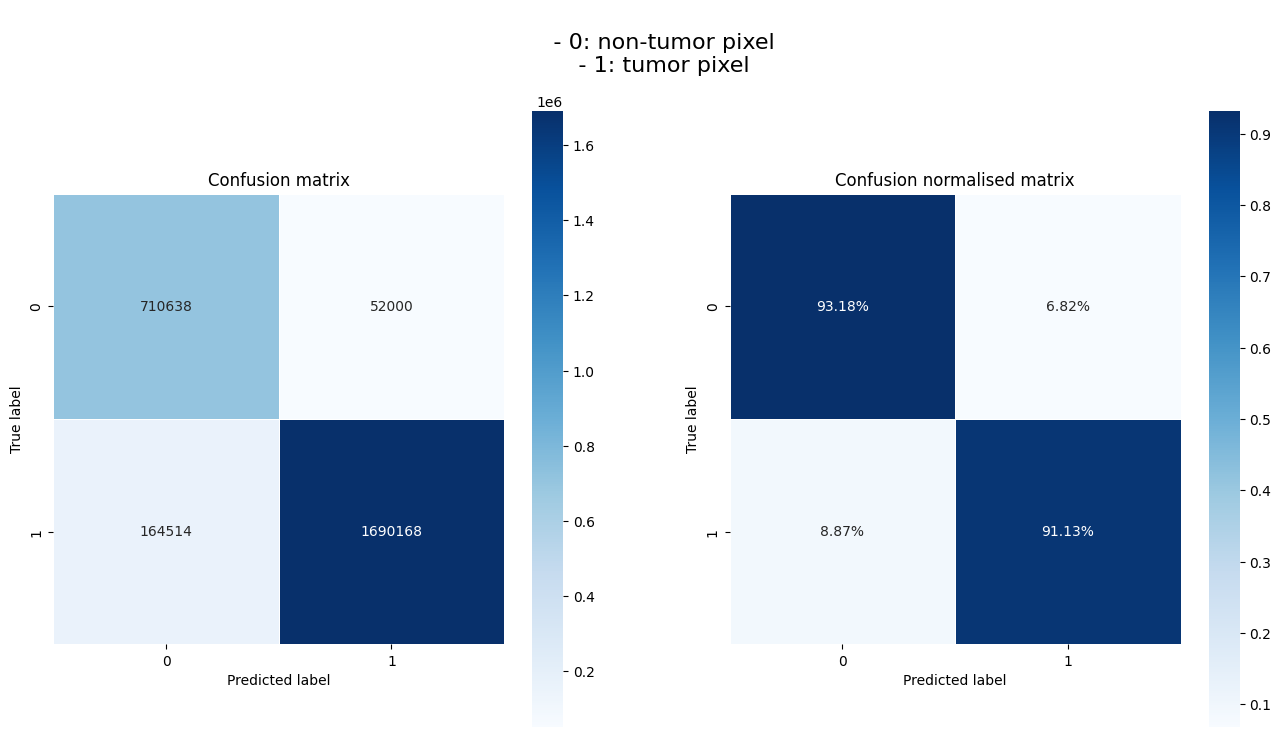

In [32]:
eval_manager.show_conf_matrices(conf_matrix, conf_norm_matrix)

### Visualisation

Visualisation of prediction border onto input image:

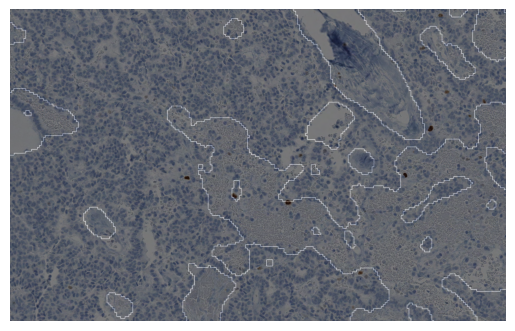

In [33]:
eval_manager.visualize_bordered_mask(testImage, thr_output, radius=2)